## Import library

In [3]:
from redditClient import redditClient
import matplotlib.pyplot as plt
import praw
import time
from datetime import datetime
import pandas as pd
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import numpy as np
import math
from collections import Counter
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rayhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Get Reddit of javascript

In [2]:
%load_ext autoreload
%autoreload 1
%aimport redditClient

In [4]:
sSubredditName = 'javascript'
client = redditClient()


# print(client.user.me()) #test client

In [5]:
subreddit = client.subreddit(sSubredditName)
data = []

# get sub-reddits
for submission in subreddit.top(limit=None):
    if submission.author is not None:
#         print(submission.title, submission.id, submission.score, submission.created)
        
        submission.comments.replace_more(limit=0)
        if len(submission.comments.list()) > 0:
            if submission.comments[0].author is not None:
#                 print(len(submission.comments.list()), submission.comments[0].body)
                data.append([submission.title, submission.id, datetime.fromtimestamp(submission.created), submission.selftext, submission.comments[0].body])

In [6]:

# put the data into a pandas dataframe
df = pd.DataFrame(data,columns=['Title','ID', 'Time', 'Body', 'TopComment'])

In [7]:
# convert into csv file
df.to_csv('dataFromReddit_js.csv', index=False) 

## Build LDA Model

In [9]:
def processText(text, tokenizer, stemmer, stopwords):
    """
    Perform tokenisation, normalisation (lower case and stemming) and stopword and twitter keyword removal.

    @param text: reddit submission or comment text
    @param tokenizer: tokeniser used.
    @param stemmer: stemmer used.
    @param stopwords: list of stopwords used

    @returns: a list of processed tokens
    """

    # covert all to lower case
    text = text.lower()
    # tokenise
    lTokens = tokenizer.tokenize(text)
    # strip whitespaces before and after
    lTokens = [token.strip() for token in lTokens]
    # stem (we use set to remove duplicates)
    lStemmedTokens = set([stemmer.stem(tok) for tok in lTokens])


    # remove stopwords, digits
    return [tok for tok in lStemmedTokens if tok not in stopwords and not tok.isdigit()]

In [10]:
# load csv file
fCsvName = 'dataFromReddit_js.csv'

# tweet to use
postTokeniser = nltk.tokenize.TweetTokenizer()
# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)
# use stopwords from nltk and a few other twitter specific terms like 'rt' (retweet)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['via']
# we use the popular Porter stemmer
postStemmer = nltk.stem.PorterStemmer()

# our term frequency counter
termFreqCounter = Counter()

In [11]:
# read csv data
csvPD=pd.read_csv(fCsvName)

# this will store the list of posts we read from subreddit
lPosts = []


data_list = csvPD['Title'].tolist()+csvPD['Body'].tolist()+csvPD['TopComment'].tolist()
data_list = [x for x in data_list if not (isinstance(x, (float, np.float64)) and np.isnan(x))]

# print out the hot submisisons
for submission in data_list:
    # tokenise, filter stopwords and get convert to lower case
    lTokens = processText(text=submission, tokenizer=postTokeniser, stemmer=postStemmer, stopwords=lStopwords)
    lPosts.append(' '.join(lTokens))


In [24]:
# remove words
remove_list = ['ha','whi','thi','tri','wa','io']

In [25]:
lPosts = [' '.join([word for word in sentence.split() if word not in remove_list]) for sentence in lPosts]

In [14]:
# LDA
# number of topics to discover (default = 10)
topicNum = 8
# maximum number of words to display per topic (default = 10)
wordNumToDisplay = 15
# this is the number of features/words to used to describe our documents
# please feel free to change to see effect
featureNum = 1500

In [15]:
for topic_num in range(1,10):
    tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
    tf = tfVectorizer.fit_transform(lPosts)
    # extract the names of the features (in our case, the words)
    tfFeatureNames = tfVectorizer.get_feature_names_out()


    #
    # LDA MODEL
    #

    # Run LDA (see documentation about what the arguments means)
    ldaModel = LatentDirichletAllocation(n_components =topic_num, max_iter=10, learning_method='online').fit(tf)
    print('topic num: ',topic_num, '\nperplexity: ', ldaModel.perplexity(tf), '\nscore: ', ldaModel.score(tf))

topic num:  1 
perplexity:  931.9317711928653 
score:  -150665.85265867176
topic num:  2 
perplexity:  992.4064168927503 
score:  -152051.32457013172
topic num:  3 
perplexity:  1056.3622620889664 
score:  -153427.55515892015
topic num:  4 
perplexity:  1127.1985558657009 
score:  -154857.78461156946
topic num:  5 
perplexity:  1132.190118160273 
score:  -154955.15098942313
topic num:  6 
perplexity:  1165.2582403460872 
score:  -155589.54128156335
topic num:  7 
perplexity:  1233.145117264764 
score:  -156837.33383016192
topic num:  8 
perplexity:  1246.4748241557224 
score:  -157074.25421110285
topic num:  9 
perplexity:  1286.354963025657 
score:  -157768.23797393142


In [16]:
topicNum = 5

In [26]:
#
# Count Vectorizer
#

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lPosts)
# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()


#
# LDA MODEL
#

# Run LDA (see documentation about what the arguments means)
ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [18]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [19]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
job https www interview com youtube watch answer awesom question share pl_gx69xpli list ask nobodi
Topic 1:
https com github work react ani sourc open project javascript web want app good use
Topic 2:
javascript use like look code new js thing realli make time featur tool understand love
Topic 3:
io cool webpack final https releas node blog org googl event chrome veri guid game
Topic 4:
use like know typescript javascript function npm let html nice exampl css code need anyth


In [20]:
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [21]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """

    # this normalises each row/topic to sum to one
    # use this normalisedComponents to display your wordclouds
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    
    topicNum = len(model.components_)
    # number of wordclouds for each row
    plotColNum = 1
    # number of wordclouds for each column
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black',scale=25)
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
    plt.rcParams['figure.figsize']=(10.0,18.0)
    plt.show(block=True)
    print()

E:\ProgrammingEnvironment\Anaconda\envs\DataScience\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
E:\ProgrammingEnvironment\Anaconda\envs\DataScience\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
E:\ProgrammingEnvironment\Anaconda\envs\DataScience\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.co

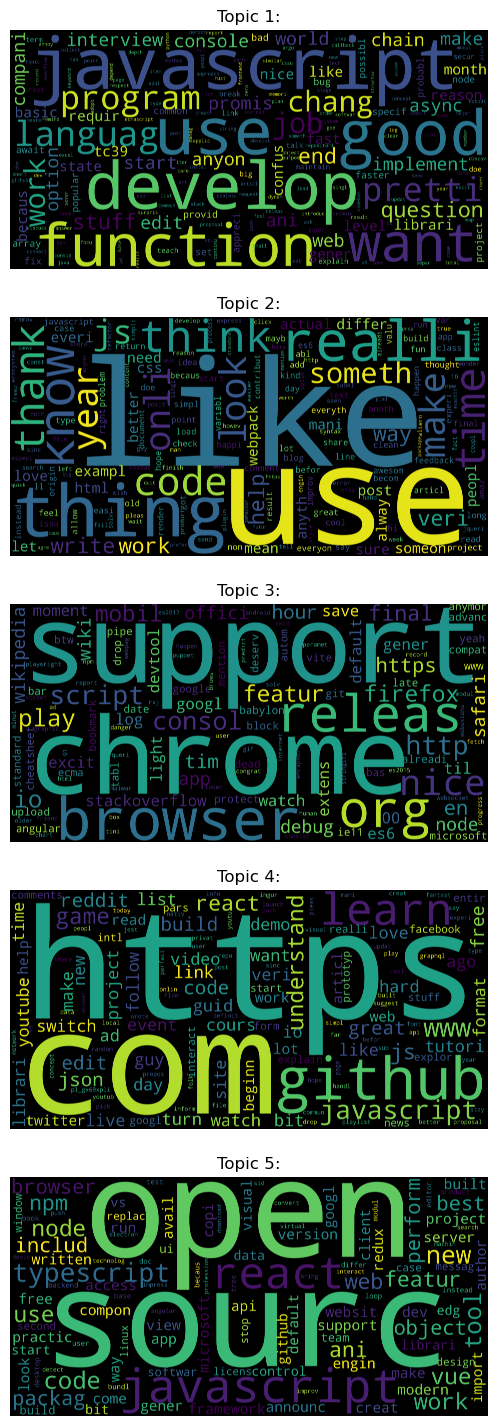

In [27]:
# display wordcloud
displayWordcloud(ldaModel, tfFeatureNames)